<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/cats_dogs_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 806M/814M [00:08<00:00, 47.1MB/s]
100% 814M/814M [00:08<00:00, 101MB/s] 


In [ ]:
import os
import cv2
import glob
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [ ]:
import zipfile

# Define the paths to the downloaded zip files and the target directories
train_zip_path = 'dogs-vs-cats-redux-kernels-edition.zip'  # Replace with the actual file name
test_zip_path = 'test.zip'  # Replace with the actual file name
target_train_dir = 'train'
target_test_dir = 'test'

# Unzip the downloaded files
with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
    train_zip.extractall(target_train_dir)



In [ ]:
with zipfile.ZipFile('/content/train/train.zip') as train_zip:
    train_zip.extractall('')

In [ ]:
with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
    train_zip.extractall(target_test_dir)

In [ ]:
with zipfile.ZipFile('/content/test/test.zip') as train_zip:
    train_zip.extractall('')

In [ ]:
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

train_files = glob('/content/train/*.jpg')
test_files = glob('/content/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return preprocess_input(img)

def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

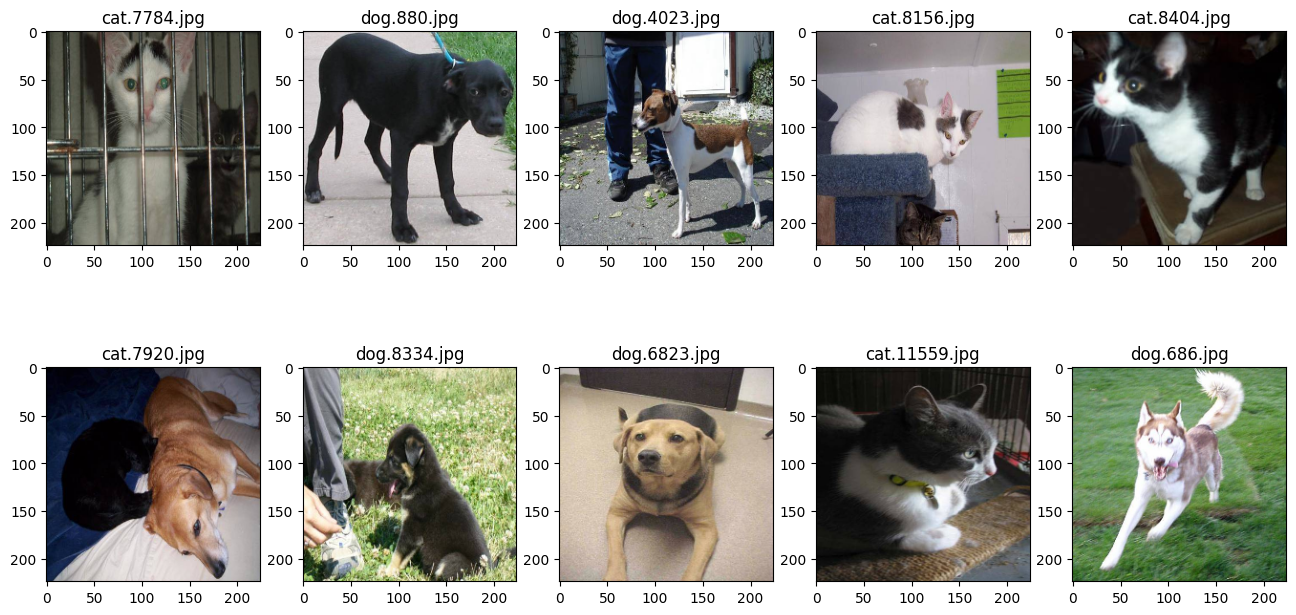

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [ ]:
base_model = Xception(weights='imagenet',
                      include_top=False,
                      pooling='max',
                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
# Замораживаем веса предобученной модели
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Добавление пользовательского слоя к предобученной модели
x = base_model.layers[-14].output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Пользовательский скрытый слой
predictions = Dense(1, activation='sigmoid')(x)  # Выходной слой для бинарной классификации

In [ ]:
# Создание итоговой модели
model = Model(inputs=base_model.input, outputs=predictions, name='cats_vs_dogs')

In [ ]:
model.summary()

Model: "cats_vs_dogs"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0

In [ ]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
val_samples = 5000 # число изображений в валидационной выборке

shuffle(train_files) # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:]) # данные читаем функцией-генератором

In [ ]:
#Переда началом обучения модели пропишем коллбэки, чтобы получать информацию о внутреннем состоянии модели в процессе обучения
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3,
                                                 verbose=0,
                                                 mode='auto')

checkpointer = tf.keras.callbacks.ModelCheckpoint('cats_dogs_Xception.hdf5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                save_freq='epoch',
                                                verbose=1,
                                                mode='auto')


history = model.fit(train_data,
                    steps_per_epoch=10,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[reduce_lr, checkpointer])

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7422
Epoch 1: val_loss improved from inf to 0.48200, saving model to cats_dogs_Xception.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 68s 6s/step - loss: 0.5919 - accuracy: 0.7422 - val_loss: 0.4820 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.9641
Epoch 2: val_loss improved from 0.48200 to 0.31872, saving model to cats_dogs_Xception.hdf5
10/10 [==============================] - 24s 3s/step - loss: 0.4086 - accuracy: 0.9641 - val_loss: 0.3187 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.9672
Epoch 3: val_loss improved from 0.31872 to 0.21900, saving model to cats_dogs_Xception.hdf5
10/10 [==============================] - 21s 2s/step - loss: 0.2699 - accuracy: 0.9672 - val_loss: 0.2190 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9734
Epoch 4: val_loss improved from 0.21900 to 0.15155, saving model to cats_dogs_Xception.hdf5
10/10 [=========

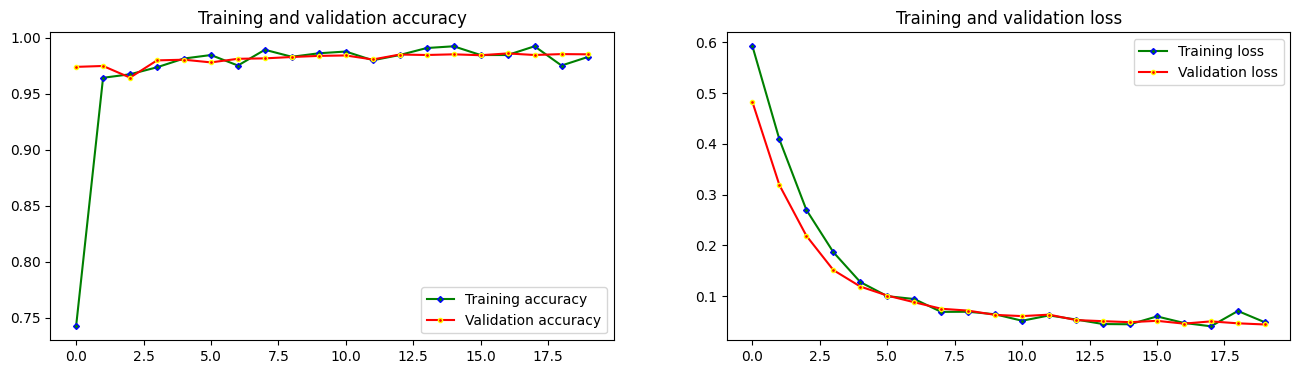

In [ ]:
#Построим график точности и потерь во время обучения.
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(16,4))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy', marker='D', mec='b', ms='3')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy', marker='o', mec='yellow', ms='3')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss', marker='D', mec='b', ms='3')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss', marker='o', mec='yellow', ms='3')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)

In [ ]:
print('Validation loss:', min(history.history['val_loss']))
print('Validation accuracy:', max(history.history['val_accuracy']))

Validation loss: 0.044506967067718506
Validation accuracy: 0.98580002784729


In [ ]:
#предсказания
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

predicted_class_indices = np.argmax(test_pred, axis = 1)

12500/12500 [==============================] - 135s 11ms/step


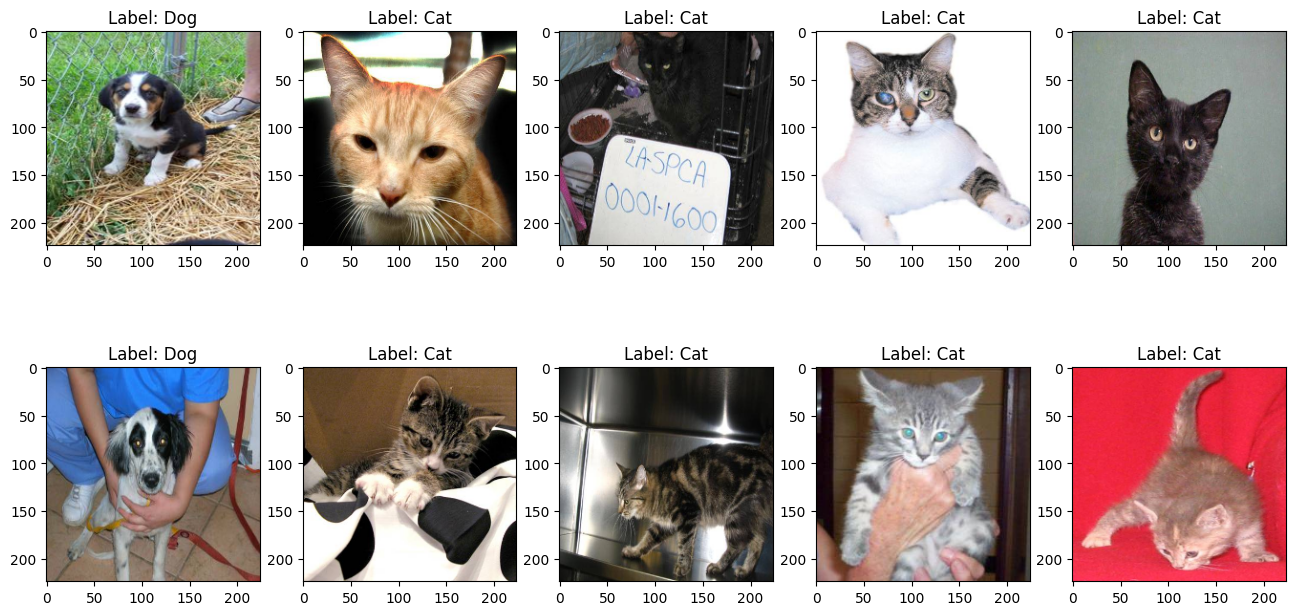

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    if score  > 0.5:
          str_label='Dog'
    elif score < 0.5:
          str_label='Cat'
    subplot.set_title("Label: {}".format(str_label))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [ ]:
import re

with open('sample_submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%.1f\n' % (re.search('(\d+).jpg$', path).group(1), score))

<ipython-input-19-ebff2fe24515>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%.1f\n' % (re.search('(\d+).jpg$', path).group(1), score))


In [ ]:
model.save('cats-dogs-Xception.keras')

In [ ]:
#Public Score = 0.19623